# Session 3 - Training a Network w/ TF

In [1]:
# imports

# check py ver
import sys
if sys.version_info < (3,4):
    print('This version of Python is too old. Please update to at least 3.4.')

# libs
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
except ImportError:
    print('You are missing some libraies!')
    # wild - we can `pip install` here!
    #!pip install "numpy>1.11.0" "matplotlib>1.5.1" "scikit-image>0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    
# tf
try:
    import tensorflow as tf
except ImportError:
    print('You need TensorFlow for this course about artistic applications of TensorFlow.')
    
try:
    from libs import utils, gif
    import IPython.display as ipyd
except ImportError:
    print('Make sure you have the libs stuff in the same directory as this notebook.')

In [2]:
# pk doesn't like the default inline code style, so let's jazz up the CSS:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code {
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
}</style>""")

In [3]:
%matplotlib inline
plt.style.use('ggplot')

## Part One - Fully Connected Network

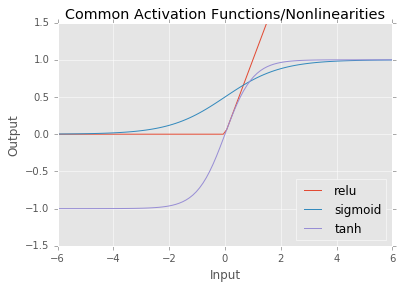

In [4]:
xs = np.linspace(-6, 6, 100)
plt.plot(xs, np.maximum(xs, 0), label='relu')
plt.plot(xs, 1 / (1 + np.exp(-xs)), label='sigmoid')
plt.plot(xs, np.tanh(xs), label='tanh')
plt.xlabel('Input')
plt.xlim([-6, 6])
plt.ylabel('Output')
plt.ylim([-1.5, 1.5])
plt.title('Common Activation Functions/Nonlinearities')
plt.legend(loc='lower right')

### Code

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')

In [6]:
W = tf.get_variable('W', shape=[2, 20], dtype=tf.float32,
                    initializer=tf.random_normal_initializer(mean=0, stddev=0.01, dtype=tf.float32))
b = tf.get_variable('b', shape=[20], dtype=tf.float32,
                    initializer=tf.constant_initializer(value=0.0, dtype=tf.float32))

In [7]:
# wx_plus_b = tf.matmul(X, W) + b
# no, we do this `bias_add` for some reason... it supports broadcasting, and restricts the bias to 1D...
# but sort of unclear why `bias_add` really exists...
h = tf.matmul(X, W)
h = tf.nn.bias_add(h, b)

In [8]:
#help(tf.get_variable)
#help(tf.random_normal_initializer)
#help(tf.constant_initializer)
#help(tf.nn.bias_add)
help(tf.nn.relu)

Help on function relu in module tensorflow.python.ops.gen_nn_ops:

relu(features, name=None)
    Computes rectified linear: `max(features, 0)`.
    
    Args:
      features: A `Tensor`. Must be one of the following types: `float32`, `float64`, `int32`, `int64`, `uint8`, `int16`, `int8`, `uint16`, `half`.
      name: A name for the operation (optional).
    
    Returns:
      A `Tensor`. Has the same type as `features`.



In [9]:
h = tf.nn.relu(h)

Next we get `linear` from the `utils` we imported... Let's copy it instead of using it directly so we can type it out and "enjoy" the contents:

In [10]:
# also need to get `flatten` from utils
def flatten(x, name=None, reuse=None):
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(x, shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2, or 4. Found:', len(dims))
    return flattened

# scope is called 'name', number of inputs is derived from the shape of `x`
def linear(x, n_output, name=None, activation=None, reuse=None):
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)
    n_input = x.get_shape().as_list()[1]
    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(name='W',
                           shape=[n_input, n_output],
                           dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='b',
                           shape=[n_output],
                           dtype=tf.float32,
                           initializer=tf.constant_initializer(0.0))
        h = tf.nn.bias_add(name='h',
                          value=tf.matmul(x, W),
                          bias=b)
        if activation:
            h = activation(h)
        return h, W

### Variable scopes

Note that since we are using `variable_scope` and telling the scope the name we would like, if there is _already_ a variable with the same name, TF will raise an exception. Consider three possible solutions:

1. reset the current graph: `tf.reset_default_graph()`
2. look for typos
3. use context managers when creating graphs and running sessions, e.g.

```
g = tf.Graph()
with tf.Session(graph=g) as sess:
    Y_pred, W = linear(X, 2, 'linear', activation=tf.nn.relu)
```

or

```
g = tf.Graph()   # ? why do this and add `g.as_default()` below?
with tf.Session(graph=g) as sess, g.as_default():
    Y_pred, W = linear(X, 2, 'linear', activation=tf.nn.relu)

```

In [11]:
h, W = linear(x=X, n_output=20, name='linear', activation=tf.nn.relu)

## Part Two - Imagine painting network

In [12]:
use_images_and_put_up_with_border_nonsense = False

In [13]:
if use_images_and_put_up_with_border_nonsense:
    dirname = "/Users/perdue/Dropbox/ArtificialIntelligence/CADL/CADL/session-1/imgs"
    filenames = [os.path.join(dirname, fname) for fname in os.listdir(dirname)]
    imgs = [plt.imread(fname) for fname in filenames]
    imgs = np.array(imgs).astype(np.float32)

    # trim off white edges
    imgs = [img_i[11:88, 13:90] for img_i in imgs]
    imgs = [resize(img_i, (100, 100)) for img_i in imgs]
    imgs = np.array(imgs).astype(np.float32)
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(imgs[49], interpolation='nearest')

In [14]:
if use_images_and_put_up_with_border_nonsense:
    for i in range(len(imgs)):
        fig = plt.figure(figsize=(1, 1))
        ax = plt.gca()
        ax.axis('off')
        im = ax.imshow(imgs[i], cmap=plt.get_cmap('jet'),
                       interpolation='nearest', vmin=0, vmax=1)
        figname = 'imgs/kadenze_%04d.png' % i
        plt.savefig(figname)
        plt.close()
        
    dirname = "/Users/perdue/Dropbox/ArtificialIntelligence/CADL/CADL/session-2/imgs"
    filenames = [os.path.join(dirname, fname) for fname in os.listdir(dirname)]
    imgs = [plt.imread(fname) for fname in filenames]
    imgs = np.array(imgs).astype(np.float32)
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(imgs[49], interpolation='nearest')

We again pick up the dumb white borders!

Should just read the image data properly from the HDF5 file... use `npymaker.py`

In [15]:
imgs = np.load('img_data.npy')
print(imgs.shape)

(100, 100, 100)


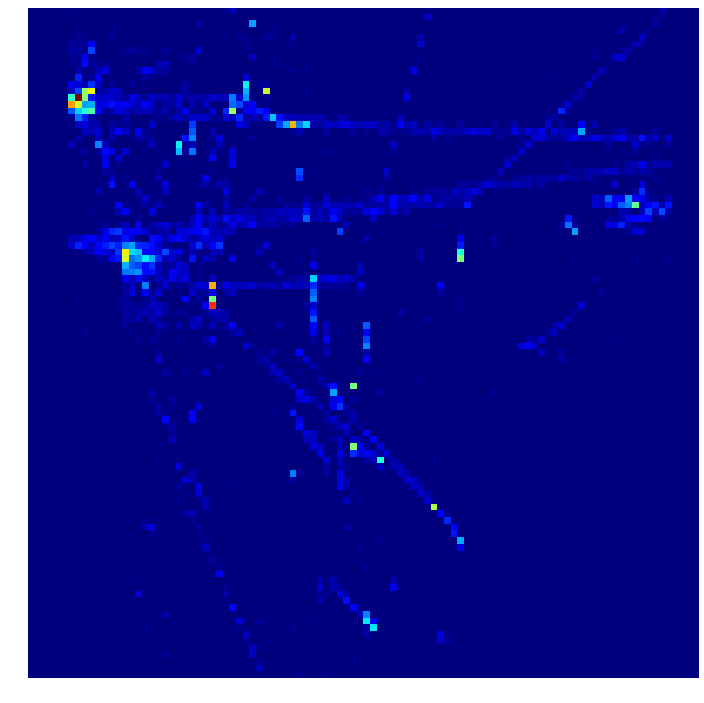

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.axis('off')
im = ax.imshow(imgs[49], interpolation='nearest')

We need to aggregate pixel locations and colors in a loop over every pixel position. PK provided a function:

In [17]:
def split_image(img):
    """
    img needs 2d shape
    """
    xs = []  # positions
    ys = []  # colors
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            xs.append([row_i, col_i])
            ys.append(img[row_i, col_i])
            
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [18]:
xs, ys = split_image(imgs[49])

In [19]:
print(xs[:10])
print(ys[:10])

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]]
[ 0.         0.         0.         0.         0.         0.         0.0109631
  0.         0.         0.       ]


PK wants us to normalize the input... but this makes no sense to me. The inputs are coordinates! So, we'll skip that.

We will do a `ys` normalization though:

In [20]:
print(np.min(ys), np.max(ys))

0.0 1.0


Hmmm, well, actually, we're already normalized. PK assumed we had 8-bit images and wanted a `/255` scaling, but I don't think that is required here.

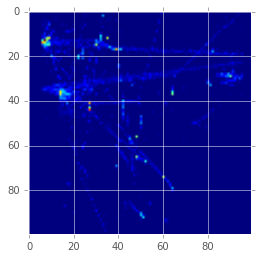

In [21]:
# we can get our image back:
plt.imshow(ys.reshape(imgs[49].shape))

Now, let's reset the graph and create placeholders for `X` and `Y`:

In [30]:
tf.reset_default_graph()

In [31]:
[print(op.name) for op in tf.get_default_graph().get_operations()]

[]

In [32]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 3], name='Y')

In [33]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'Y']

Now, let's create a 6-layer deep network with 20 neurons in each layer.

```
h1 = phi(X W1 + b1)
h2 = phi(h1 W2 + b2)
...
h6 = phi(h5 W6 + b6)
Yhat = phi(H6 W7 + b7)
```


In [34]:
# recall:
#  def linear(x, n_output, name=None, activation=None, reuse=None)
# `linear` returns activated layer, W

n_neurons = [2, 20, 20, 20, 20, 20, 20, 3]  # len==8
current_input = X
for layer_i in range(1, len(n_neurons)):
    # loop starting after the data input layer, use `linear` function to build params, etc.
    layer_name = 'layer_' + str(layer_i)
    act_fun = tf.nn.relu if (layer_i + 1) < len(n_neurons) else None
    current_input, _ = linear(x=current_input, n_output=n_neurons[layer_i], name=layer_name, activation=act_fun)
Yhat = current_input

In [36]:
assert(X.get_shape().as_list() == [None, 2])
assert(Yhat.get_shape().as_list() == [None, 3])
assert(Y.get_shape().as_list() == [None, 3])